## File: occupations_DAG_edsl.ipynb
#### Summary: This notebook creates DAGs and PM of a given occupation.

#### By: Peyman Shahidi
#### First Created: June 15, 2024

#### Last Edit by Peyman on June 26, 2024

In [173]:
#Python
import os
import getpass
import glob
import numpy as np
import pandas as pd
import random
import networkx as nx
import requests
import re

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [174]:
# determine user
user = getpass.getuser()
if user == 'peymansh':
    main_folder_path = '/Users/peymansh/Dropbox (MIT)/Research/AI and Occupations/ai-exposure'
    data_path = f'{main_folder_path}/output'
    output_path = f'{main_folder_path}/output/daily_tasks_occupations_analysis'

# Functions

In [175]:
def create_adjacency_matrix(adjacency_matrix_df):
    # keep names for node labels
    tasks = adjacency_matrix_df.columns.tolist()
    tasks = [x.split()[0] for x in tasks]
    node_labels = {value: index for value, index in enumerate(tasks)}
    print(node_labels) 

    # convert adjacency matrix to numpy array for graph depiction
    adjacency_matrix = adjacency_matrix_df.values
    adjacency_matrix = np.nan_to_num(adjacency_matrix, nan=0.0)
    return adjacency_matrix


# Hacky way of fixing "Sink" node
def add_sink_node(dag_matrix, occupation):
    n = dag_matrix.shape[0]
    tasks = dag_matrix.columns.tolist()
    
    if '"Sink"' in tasks:
        return dag_matrix
    elif occupation == 'travelAgents':
        dag_matrix.loc['"Sink"'] = [0] * n
        dag_matrix['"Sink"'] = [0, 0, 0, 0, 0, 0, 1, 1, 0]
    elif occupation == 'insuranceUnderwriters':
        dag_matrix.loc['"Sink"'] = [0] * n
        dag_matrix['"Sink"'] = [1, 0, 0, 1, 0, 1, 0, 0]
    
    return dag_matrix 

In [176]:
def draw_dag_line(occupation, focal_task, all_tasks):
    tasks = copy.deepcopy(all_tasks)
    tasks.remove(focal_task)
    q = QuestionCheckBox(
        question_name = "dag",
        question_text = dedent("""\
            Consider this {{ occupation }}. 
            And consider this task: {{ task }}. 
            Of the following tasks, which task is this task an input to?
            Check all that apply.
            """),
        question_options = tasks
    )
    scenario = Scenario({'occupation':occupation, 'task': focal_task})
    return q.by(m4).by(scenario).run()


def dict_to_matrix(dictionary):
    from collections import OrderedDict

    # Use OrderedDict to maintain the insertion order of keys
    unique_keys = OrderedDict.fromkeys(dictionary.keys())
    unique_values = OrderedDict.fromkeys(val for values in dictionary.values() for val in values)
    
    # Combine keys and values into a single list while maintaining their order
    all_labels = list(unique_keys) + [val for val in unique_values if val not in unique_keys]
    
    # Create an index map for the labels
    label_index = {label: idx for idx, label in enumerate(all_labels)}
    
    # Initialize the matrix with zeros
    size = len(all_labels)
    matrix = np.zeros((size, size), dtype=int)
    
    # Populate the matrix
    for key, values in dictionary.items():
        i = label_index[key]
        for value in values:
            j = label_index[value]
            matrix[i][j] = 1
    
    return matrix, all_labels



def create_dag(occupation, tasks):
    dag = dict({})
    for task in tasks: 
        dag[task] = draw_dag_line(occupation, task, tasks).select("dag").first()

    # Convert DAG from dictionary to matrix
    dag_matrix, dag_matrix_labels = dict_to_matrix(dag)

    return dag, dag_matrix, dag_matrix_labels



def export_DAG_matrix_to_csv(matrix, labels, filename):
    # Create a DataFrame from the matrix
    df = pd.DataFrame(matrix, index=labels, columns=labels)
    
    # Export the DataFrame to a CSV file
    df.to_csv(filename)

## Occupation Information

In [177]:
occupation = 'travelAgents'
GPT_input_occupation = 'Travel agent'
plot_title_occupation = 'Travel Agents'


# occupation = 'pileDriverOperators'
# GPT_input_occupation = 'Pile dirver operator'
# plot_title_occupation = 'Pile Driver Operators'


# occupation = 'insuranceUnderwriters'
# GPT_input_occupation = 'Insurance underwriter'
# plot_title_occupation = 'Insurance Underwriters'


# occupation = 'shampooers'
# GPT_input_occupation = 'Shampooer'
# plot_title_occupation = 'Shampooers'

## Node Positions for Graphs

In [178]:
def graph_node_positions(pos, occupation):
    
    if occupation == 'travelAgents':
        pos[0] = (0, 0.0025) # Collect
        pos[1] = (-1.75, -0.005) # Converse
        pos[2] = (-.75, 0.0025) # Compute
        pos[3] = (0.5, 0) # Book 
        pos[4] = (-1.25, 0) # Plan
        pos[5] = (-1.75, 0.005) # Provide
        pos[6] = (1, 0.005) # Print
        pos[7] = (1, -0.005) # Record
        pos[8] = (1.5, 0) # Sink
        
    elif occupation == 'pileDriverOperators':
        pos[0] = (.25, .05) # Move hand
        pos[1] = (-1, 0) # Conduct
        pos[2] = (1, 0) # Drive
        pos[3] = (0.25, .02) # Move levers
        pos[4] = (-.5, 0) # Clean

    elif occupation == 'insuranceUnderwriters':
        pos[0] = (0.5, .1) # Decline
        pos[1] = (0, 0) # Write
        pos[2] = (0.25, -0.2) # Evaluate
        pos[3] = (0.5, 0) # Decrease 
        pos[4] = (0.25, 0.2) # Review
        pos[5] = (0.5, -.1) # Authorize
        pos[6] = (-.25, 0) # Examine
        pos[7] = (0.75, 0) # Sink

    elif occupation == 'shampooers':
        pos[0] = (0.25, -0.005) # Massage
        pos[1] = (0, 0) # Advise
        pos[2] = (0.25, 0.005) # Treat
        pos[3] = (0.5, 0) # Maintain

    return pos

## Occupation DAG - Manual Version

In [179]:
# Read the adjacency matrix
file_path = f'{data_path}/daily_tasks_occupations_analysis/{occupation}'
adjacency_matrix = pd.read_csv(f'{file_path}/{occupation}_AM.csv', index_col=0)
adjacency_matrix = add_sink_node(adjacency_matrix, occupation)


# create dictrionary for later
tasks_dict = {i: row_name for i, row_name in enumerate(adjacency_matrix.index)}
tasks_dict = {value: key for key, value in tasks_dict.items()}



# keep names for node labels
tasks = adjacency_matrix.columns.tolist()
node_labels = []
for task in tasks:
    # Check if the string starts with "Move"
    if task.startswith("Move"):
        # If it does, keep the first two words
        modified_task = ' '.join(task.split()[:2])
    else:
        # Otherwise, keep the first two words as is
        modified_task = task.split()[0]
    # Add the modified string to the new list
    node_labels.append(modified_task)
node_labels = {value: index for value, index in enumerate(node_labels)}
print(node_labels)

# convert adjacency matrix to numpy array for graph depiction
adjacency_matrix = adjacency_matrix.values
adjacency_matrix = np.nan_to_num(adjacency_matrix, nan=0.0)

{0: 'Move hand', 1: 'Conduct', 2: 'Drive', 3: 'Move levers', 4: 'Clean,'}


## Occupation DAG - GPT Version

In [180]:
import copy
import random

from edsl.questions import QuestionCheckBox, QuestionFreeText
from edsl import Scenario, Model
from edsl.questions import QuestionMultipleChoice
from itertools import combinations
from edsl.questions.derived.QuestionLinearScale import QuestionLinearScale
from textwrap import dedent

Model.available()
m35 = Model('gpt-3.5-turbo')
m4 = Model('gpt-4o')

In [181]:
# Prompts GPT and create DAG
if '"Sink"' in tasks:
    tasks.remove('"Sink"')
GPT_dag_dict, GPT_dag_matrix_raw, GPT_dag_matrix_labels = create_dag(GPT_input_occupation, tasks)

## Some cases of both A --> B and B --> A edges present in GPT DAG, pick only one

In [182]:
def find_symmetric_ones(matrix):
    indices = []
    n = matrix.shape[0]  # assuming matrix is square
    for i in range(n):
        for j in range(i+1, n):  # no need to check the diagonal or repeat pairs
            if matrix[i, j] == 1 and matrix[j, i] == 1:
                indices.append((i, j))
                indices.append((j, i))
    return indices

symmetric_edges = find_symmetric_ones(GPT_dag_matrix_raw)
print(symmetric_edges[:4])

[(0, 2), (2, 0), (2, 3), (3, 2)]


In [183]:
def decide_on_symmetric_edges(occupation, tasks, symmetric_edges):
    symmetric_edges = np.array(symmetric_edges)
    task_A_list = symmetric_edges[:, 0]
    task_B_list = symmetric_edges[:, 1]
    scenarios = [Scenario({"occupation": occupation, "task_A": tasks[task_A], "task_B": tasks[task_B]}) 
        for task_A, task_B in zip(task_A_list, task_B_list)]

    q = QuestionMultipleChoice(
        question_name = "ordering",
        question_text = dedent("""\
            Consider this {{ occupation }}. 
            And consider these two tasks: 
            A) {{ task_A }} 
            B) {{ task_B }}
            What is the relationship between these tasks?
            """),
        question_options = [
            "A would be done first", 
            "B would be done first",]
    )
    results = q.by(m4).by(scenarios).run(progress_bar = True)
    return results

results = decide_on_symmetric_edges(GPT_input_occupation, tasks, symmetric_edges)
#results.select("task_A", "task_B", "ordering").print()

Output()

In [184]:
# Convert results to pandas df
GPT_twoSided_edges = results.select("task_A", "task_B", "ordering").to_pandas()

# Subset rows where A is done first or B is done first
a_before_b_df = GPT_twoSided_edges[GPT_twoSided_edges['answer.ordering'] == 'A would be done first']
b_before_a_df = GPT_twoSided_edges[GPT_twoSided_edges['answer.ordering'] == 'B would be done first']

# Adjust the GPT DAG matrix
GPT_dag_matrix = GPT_dag_matrix_raw.copy()

# if A is done before B then edge from B to A = 0
for index, row in a_before_b_df.iterrows():
    task_colA = tasks_dict[row['scenario.task_A']]
    task_colB = tasks_dict[row['scenario.task_B']]
    GPT_dag_matrix[task_colB, task_colA] = 0
    
# if B is done before A then edge from A to B = 0
for index, row in b_before_a_df.iterrows():
    task_colA = tasks_dict[row['scenario.task_A']]
    task_colB = tasks_dict[row['scenario.task_B']]
    GPT_dag_matrix[task_colA, task_colB] = 0

# Save GPT DAG output
filename = f'{data_path}/daily_tasks_occupations_analysis/{occupation}/{occupation}_GPT_DAG.csv'
export_DAG_matrix_to_csv(GPT_dag_matrix, GPT_dag_matrix_labels, filename)


## Plot Manual vs. GPT DAGs

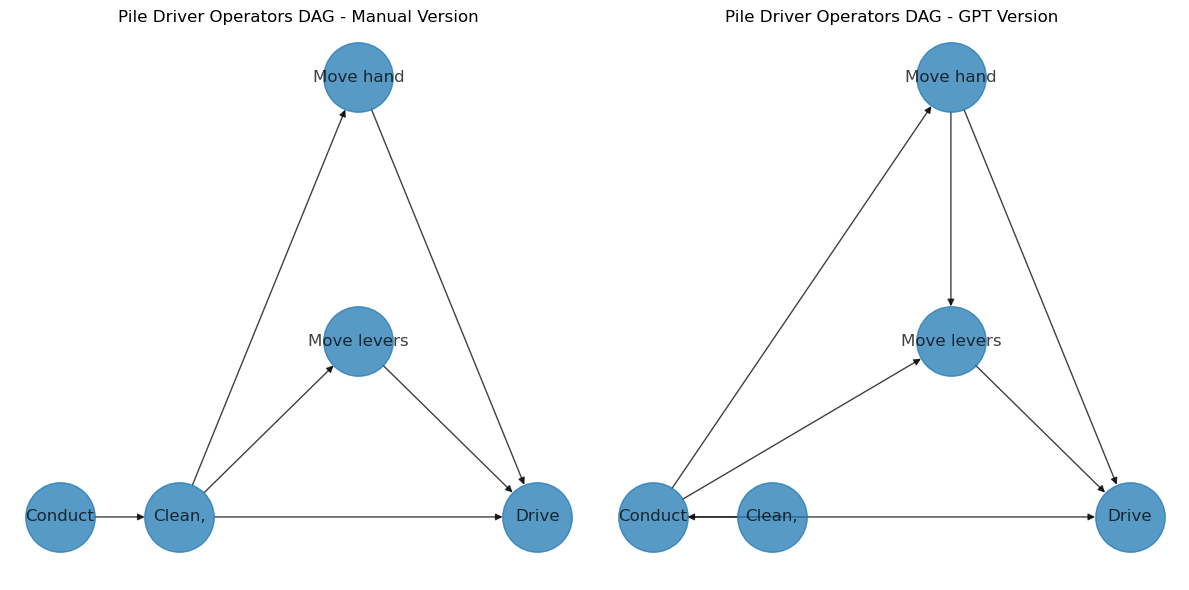

In [185]:
# Create a figure with two subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Draw Manual version
G1 = nx.DiGraph(adjacency_matrix)
pos1 = nx.spring_layout(G1)
pos1 = graph_node_positions(pos1, occupation)
nx.draw(G1, pos1, with_labels=True, ax=ax1, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
ax1.set_title(f'{plot_title_occupation} DAG - Manual Version')

# Draw GPT version
G2 = nx.DiGraph(GPT_dag_matrix)
pos2 = nx.spring_layout(G2)
pos2 = graph_node_positions(pos2, occupation)
nx.draw(G2, pos2, with_labels=True, ax=ax2, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
ax2.set_title(f'{plot_title_occupation} DAG - GPT Version')

# Adjust layout and save
plt.tight_layout()
plt.savefig(f'{file_path}/{occupation}_DAG.png')

## Compare Manual and GPT DAGs: get edges present in one but not the other

In [186]:
# remove the sink node from Manual version if it's present
if adjacency_matrix.shape[0] != GPT_dag_matrix.shape[0]:
    adjacency_matrix = adjacency_matrix[:-1,:-1]

In [187]:
# Subtract the GPT matrix from Manual
diff_matrix = adjacency_matrix - GPT_dag_matrix

# subset edges which are in Manual DAG but not in GPT's
inManual_notInGPT = diff_matrix.copy()
inManual_notInGPT[inManual_notInGPT < 0] = 0

# subset edges which are in GPT's DAG but not in Manual's
inGPT_notInManual = diff_matrix.copy()
inGPT_notInManual[inGPT_notInManual > 0] = 0
inGPT_notInManual[inGPT_notInManual < 0] = 1

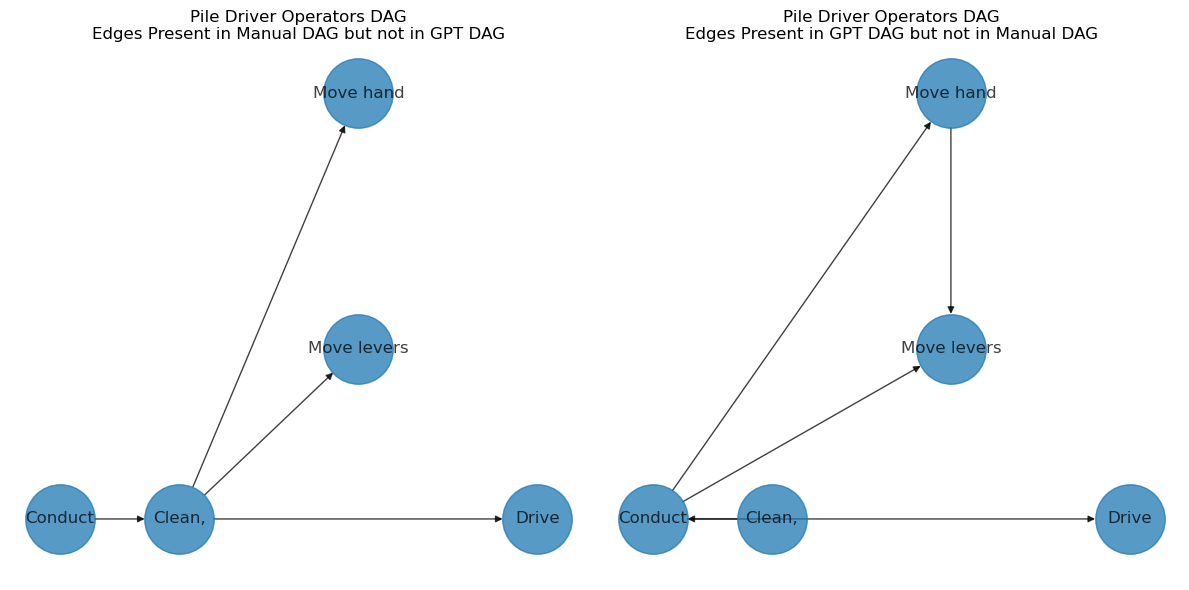

In [188]:
# Create a figure with two subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Draw version with Manual edges not present in GPT
G1 = nx.DiGraph(inManual_notInGPT)
pos1 = nx.spring_layout(G1)
pos1 = graph_node_positions(pos1, occupation)
nx.draw(G1, pos1, with_labels=True, ax=ax1, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
ax1.set_title(f'{plot_title_occupation} DAG\nEdges Present in Manual DAG but not in GPT DAG')

# Draw GPT version
G2 = nx.DiGraph(inGPT_notInManual)
pos2 = nx.spring_layout(G2)
pos2 = graph_node_positions(pos2, occupation)
nx.draw(G2, pos2, with_labels=True, ax=ax2, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
ax2.set_title(f'{plot_title_occupation} DAG\nEdges Present in GPT DAG but not in Manual DAG')

# Adjust layout and save
plt.tight_layout()
plt.savefig(f'{file_path}/{occupation}_edgeComparison.png')

## GPT Precedence Matrix (PM)
#### compare each pair of tasks. if they're part of same sequence determine which is done first

In [189]:
def task_relationships(occupation, tasks):
    #random.shuffle(tasks)
    scenarios = [Scenario({"occupation": occupation, "task_A": task_A, "task_B": task_B}) 
        for task_A, task_B in combinations(tasks, 2)]

    q = QuestionMultipleChoice(
        question_name = "ordering",
        question_text = dedent("""\
            Consider this {{ occupation }}. 
            And consider these two tasks: 
            A) {{ task_A }} 
            B) {{ task_B }}
            What is the relationship between these tasks?
            """),
        question_options = [
            "A would be done first", 
            "B would be done first", 
            "Could be done in either order, but still part of the same task", 
            "Not part of the same task sequence"]
    )
    results = q.by(m4).by(scenarios).run(progress_bar = True)
    return results

results = task_relationships(GPT_input_occupation, tasks)
results.select("task_A", "task_B", "ordering").print()

Output()

scenario.task_A,scenario.task_B,answer.ordering
"Move hand and foot levers of hoisting equipment to position piling leads, hoist piling into leads, and position hammers over pilings.",Conduct pre-operational checks on equipment to ensure proper functioning.,B would be done first
"Move hand and foot levers of hoisting equipment to position piling leads, hoist piling into leads, and position hammers over pilings.","Drive pilings to provide support for buildings or other structures, using heavy equipment with a pile driver head.",A would be done first
"Move hand and foot levers of hoisting equipment to position piling leads, hoist piling into leads, and position hammers over pilings.","Move levers and turn valves to activate power hammers, or to raise and lower drophammers that drive piles to required depths.",A would be done first
"Move hand and foot levers of hoisting equipment to position piling leads, hoist piling into leads, and position hammers over pilings.","Clean, lubricate, and refill equipment.",A would be done first
Conduct pre-operational checks on equipment to ensure proper functioning.,"Drive pilings to provide support for buildings or other structures, using heavy equipment with a pile driver head.",A would be done first
Conduct pre-operational checks on equipment to ensure proper functioning.,"Move levers and turn valves to activate power hammers, or to raise and lower drophammers that drive piles to required depths.",A would be done first
Conduct pre-operational checks on equipment to ensure proper functioning.,"Clean, lubricate, and refill equipment.",A would be done first
"Drive pilings to provide support for buildings or other structures, using heavy equipment with a pile driver head.","Move levers and turn valves to activate power hammers, or to raise and lower drophammers that drive piles to required depths.","Could be done in either order, but still part of the same task"
"Drive pilings to provide support for buildings or other structures, using heavy equipment with a pile driver head.","Clean, lubricate, and refill equipment.",B would be done first
"Move levers and turn valves to activate power hammers, or to raise and lower drophammers that drive piles to required depths.","Clean, lubricate, and refill equipment.",B would be done first


In [190]:
# Convert results to pandas df
task_relationships_df = results.select("task_A", "task_B", "ordering").to_pandas()

# Sort df on task_A column so it follows the tasks list order
task_relationships_df['scenario.task_A'] = pd.Categorical(task_relationships_df['scenario.task_A'], categories=tasks, ordered=True)

# Sort the DataFrame based on column 'scenario.task_A'
task_relationships_df = task_relationships_df.sort_values('scenario.task_A')

In [191]:
# Create empty matrix 
pm_matrix_raw = np.zeros((len(tasks), len(tasks)))

# Subset rows where A is done first or B is done first
a_before_b_df = task_relationships_df[task_relationships_df['answer.ordering'] == 'A would be done first']
b_before_a_df = task_relationships_df[task_relationships_df['answer.ordering'] == 'B would be done first']
both_tasks = task_relationships_df[task_relationships_df['answer.ordering'] == 'Could be done in either order, but still part of the same task']

# Populate the matrix
# if A is done before B then edge is from A to B: row A column B element = 1
for index, row in a_before_b_df.iterrows():
    task_colA = tasks_dict[row['scenario.task_A']]
    task_colB = tasks_dict[row['scenario.task_B']]
    pm_matrix_raw[task_colA][task_colB] = 1
    
# if B is done before A then edge is from B to A: row B column A element = 1
for index, row in b_before_a_df.iterrows():
    task_colA = tasks_dict[row['scenario.task_A']]
    task_colB = tasks_dict[row['scenario.task_B']]
    pm_matrix_raw[task_colB][task_colA] = 1

# if could be done in either order, add 1 to both - decide later to drop which
for index, row in both_tasks.iterrows():
    task_colA = tasks_dict[row['scenario.task_A']]
    task_colB = tasks_dict[row['scenario.task_B']]
    pm_matrix_raw[task_colA][task_colB] = 1
    pm_matrix_raw[task_colB][task_colA] = 1

In [192]:
# Adjust the GPT DAG matrix
pm_matrix = pm_matrix_raw.copy()

# Decide which edge of both sided cases to keep
symmetric_edges_pm = find_symmetric_ones(pm_matrix)
if len(symmetric_edges_pm) > 0:
    results = decide_on_symmetric_edges(GPT_input_occupation, tasks, symmetric_edges_pm)
    # Convert results to pandas df
    PM_twoSided_edges = results.select("task_A", "task_B", "ordering").to_pandas()

    # Subset rows where A is done first or B is done first
    a_before_b_df = PM_twoSided_edges[PM_twoSided_edges['answer.ordering'] == 'A would be done first']
    b_before_a_df = PM_twoSided_edges[PM_twoSided_edges['answer.ordering'] == 'B would be done first']

    # if A is done before B then edge from B to A = 0
    for index, row in a_before_b_df.iterrows():
        task_colA = tasks_dict[row['scenario.task_A']]
        task_colB = tasks_dict[row['scenario.task_B']]
        pm_matrix[task_colB, task_colA] = 0
        
    # if B is done before A then edge from A to B = 0
    for index, row in b_before_a_df.iterrows():
        task_colA = tasks_dict[row['scenario.task_A']]
        task_colB = tasks_dict[row['scenario.task_B']]
        pm_matrix[task_colA, task_colB] = 0

# Save output as python df
pm_matrix_df = pd.DataFrame(pm_matrix, index=tasks, columns=tasks)
pm_matrix_df.to_csv(f'{data_path}/daily_tasks_occupations_analysis/{occupation}/{occupation}_GPT_PM.csv', columns=tasks, index=True)

Output()

### Plot PM DAG against Manual and GPT DAGs

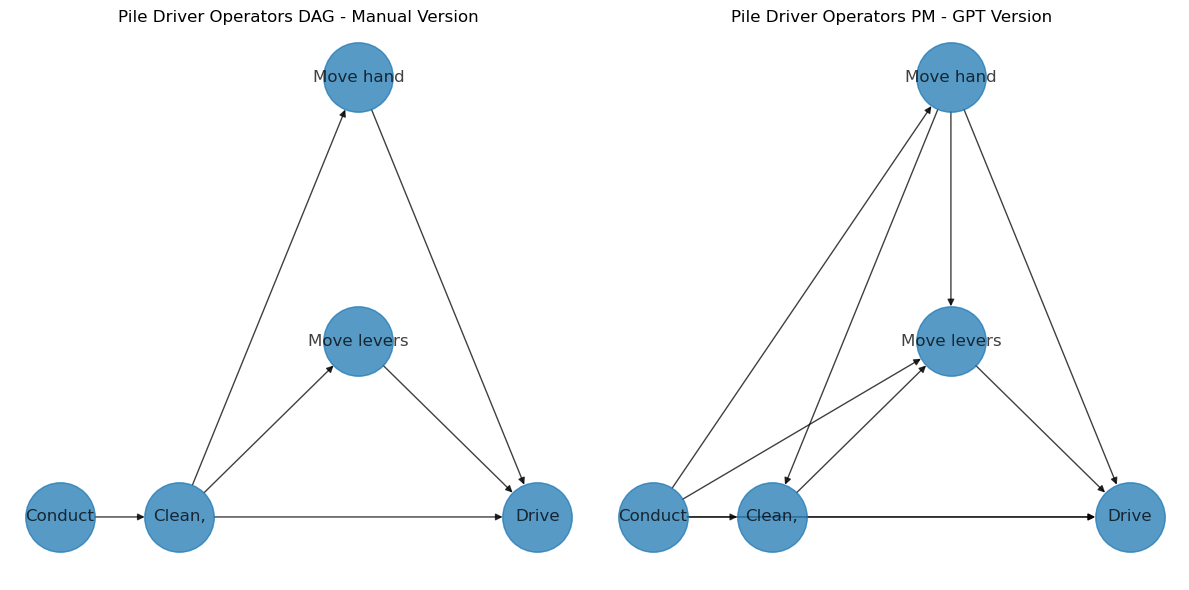

In [193]:
# Create a figure with two subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Draw version with Manual edges not present in GPT
G1 = nx.DiGraph(adjacency_matrix)
pos1 = nx.spring_layout(G1)
pos1 = graph_node_positions(pos1, occupation)
nx.draw(G1, pos1, with_labels=True, ax=ax1, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
ax1.set_title(f'{plot_title_occupation} DAG - Manual Version')

# Draw GPT version
G2 = nx.DiGraph(pm_matrix)
pos2 = nx.spring_layout(G2)
pos2 = graph_node_positions(pos2, occupation)
nx.draw(G2, pos2, with_labels=True, ax=ax2, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
ax2.set_title(f'{plot_title_occupation} PM - GPT Version')

# Adjust layout and save
plt.tight_layout()
plt.savefig(f'{file_path}/{occupation}_manualDAGvsPM.png')

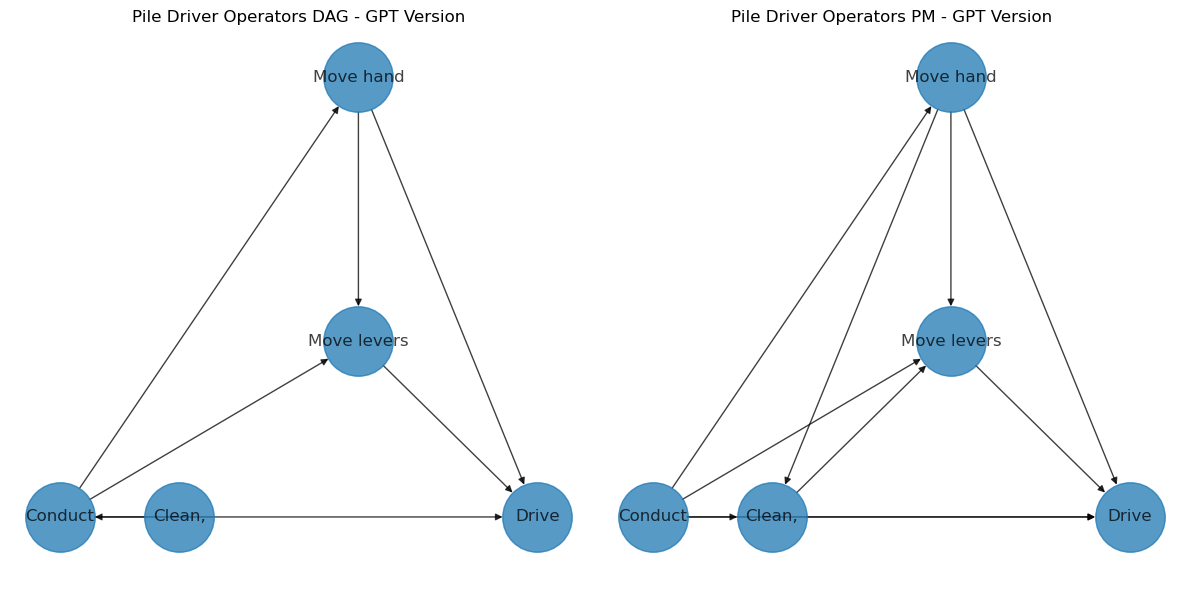

In [194]:
# Create a figure with two subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Draw version with Manual edges not present in GPT
G1 = nx.DiGraph(GPT_dag_matrix)
pos1 = nx.spring_layout(G1)
pos1 = graph_node_positions(pos1, occupation)
nx.draw(G1, pos1, with_labels=True, ax=ax1, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
ax1.set_title(f'{plot_title_occupation} DAG - GPT Version')

# Draw GPT version
G2 = nx.DiGraph(pm_matrix)
pos2 = nx.spring_layout(G2)
pos2 = graph_node_positions(pos2, occupation)
nx.draw(G2, pos2, with_labels=True, ax=ax2, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
ax2.set_title(f'{plot_title_occupation} PM - GPT Version')

# Adjust layout and save
plt.tight_layout()
plt.savefig(f'{file_path}/{occupation}_GPTDAGvsPM.png')